# ARIMA model to predict gas prices
This notebook examines and predicts gas prices in the United States, the dataset used in this notebook was provided by the U.S. Energy Information Administration (Jan 2021) through Mau Ruanovau's Kaggle profile. Data from 2005 through January 2021 is examined. Much of the python code used in this notebook was derived from an article by Jason Brownlee that may be accessed at https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python.

In [1]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Reading the data
The dataset used for this notebook provides weekly gas prices for regular, mid-grade, premium gasoline as well as  diesel.

In [2]:
# import data
gas_df = pd.read_csv('PET_PRI_GND_DCUS_NUS_W.csv')

# Examining the data

In [3]:
# examine data
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1361 entries, 0 to 1360
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1361 non-null   object 
 1   A1      1361 non-null   float64
 2   A2      1361 non-null   float64
 3   A3      1361 non-null   float64
 4   R1      1361 non-null   float64
 5   R2      1361 non-null   float64
 6   R3      1361 non-null   float64
 7   M1      1361 non-null   float64
 8   M2      1361 non-null   float64
 9   M3      1361 non-null   float64
 10  P1      1361 non-null   float64
 11  P2      1361 non-null   float64
 12  P3      1361 non-null   float64
 13  D1      1361 non-null   float64
dtypes: float64(13), object(1)
memory usage: 149.0+ KB


The dataset contains 1361 rows and 13 columns. All gas price variables are of float type, the Date variable is of object type. 

In [4]:
gas_df.head()

,Date,A1,A2,A3,R1,R2,R3,M1,M2,M3,P1,P2,P3,D1
0,01/02/1995,1.127,1.104,1.231,1.079,1.063,1.167,1.170,1.159,1.298,1.272,1.250,1.386,1.104
1,01/09/1995,1.134,1.111,1.232,1.086,1.070,1.169,1.177,1.164,1.300,1.279,1.256,1.387,1.102
2,01/16/1995,1.126,1.102,1.231,1.078,1.062,1.169,1.168,1.155,1.299,1.271,1.249,1.385,1.100
3,01/23/1995,1.132,1.110,1.226,1.083,1.068,1.165,1.177,1.165,1.296,1.277,1.256,1.378,1.095
4,01/30/1995,1.131,1.109,1.221,1.083,1.068,1.162,1.176,1.163,1.291,1.275,1.255,1.370,1.090


# Checking for missing values

In [5]:
# check for missing values
gas_df.isnull().sum()

Date    0
A1      0
A2      0
A3      0
R1      0
R2      0
R3      0
M1      0
M2      0
M3      0
P1      0
P2      0
P3      0
D1      0
dtype: int64

The dataset contains no missing values. 

# Converting Date variable to DateTime and setting Date as index

In [6]:
# set Date variable as DateTime type
gas_df['Date'] = pd.to_datetime(gas_df['Date'])

In [7]:
# set Date variable as DataFrame index
gas_df.set_index('Date',inplace=True)
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1361 entries, 1995-01-02 to 2021-01-25
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      1361 non-null   float64
 1   A2      1361 non-null   float64
 2   A3      1361 non-null   float64
 3   R1      1361 non-null   float64
 4   R2      1361 non-null   float64
 5   R3      1361 non-null   float64
 6   M1      1361 non-null   float64
 7   M2      1361 non-null   float64
 8   M3      1361 non-null   float64
 9   P1      1361 non-null   float64
 10  P2      1361 non-null   float64
 11  P3      1361 non-null   float64
 12  D1      1361 non-null   float64
dtypes: float64(13)
memory usage: 148.9 KB


In [8]:
gas_df.index.min()

Timestamp('1995-01-02 00:00:00')

# Resample DataFrame to create monthly data
From this point forward, gas prices will be evaluated by monthly averages.

In [9]:
gas_df = gas_df.resample('M').mean()

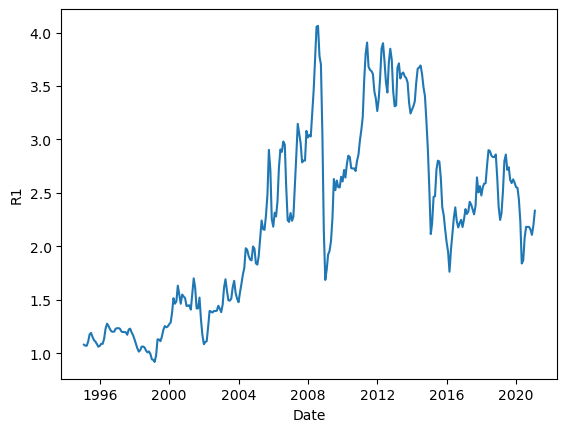

In [10]:
sns.lineplot(x=gas_df.index,y=gas_df['R1'])
plt.show()

# Removing dates prior to 2004
Removing data prior to 2004 will create a much more stationary dataset for the ARIMA Model.

In [11]:
# remove dates prior to 2004 from DataFrame
starting_date = pd.to_datetime('2005-01-01 00:00:00')
gas_df = gas_df[starting_date:]

# Examining price of all regular gas prices from 2005 through January 2021

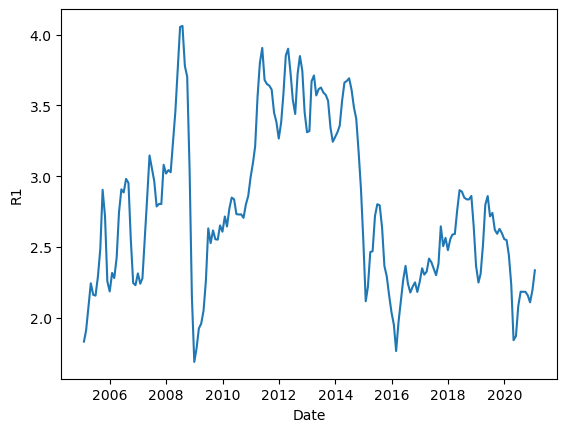

In [12]:
sns.lineplot(x=gas_df.index,y=gas_df['R1'])
plt.show()

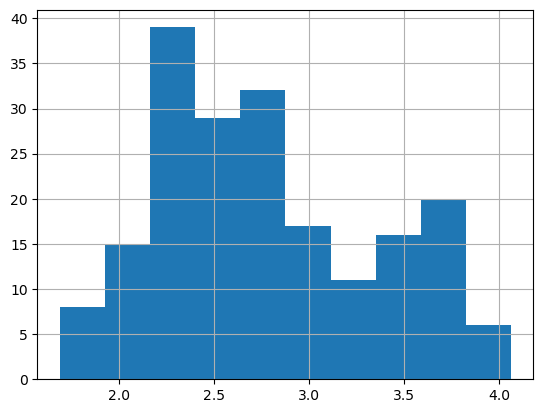

In [13]:
gas_df['R1'].hist()
plt.show()

# Evaluating Stationarity of regular gas prices

To evaluate the stationarity of a series, it's helpful to split the series into 2 halfs and then compare the mean and variance of those halfs. 

In [14]:
# check for mean and variance of split dataframe to check for stationarity
X = gas_df['R1']
half_split = len(X) / 2
X1, X2 = X[0:int(half_split)], X[int(half_split):]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
std1, std2 = X1.std(ddof=1), X2.std(ddof=1)
print(f'mean1 = {mean1:.3f}, mean2 = {mean2:.3f}')
print(f'variance1 = {var1:.3f}, variance2 = {var2:.3f}')

mean1 = 2.895, mean2 = 2.665
variance1 = 0.356, variance2 = 0.272


The mean and variance of the split series appear relatively close. The Augmented Dickey-Fuller test can be used to  determinine whether a series is stationary or not.

In [15]:
# perform Augmented Dickey-Fuller test
result = adfuller(gas_df['R1'])
print(f'ADF Statistic: {result[0]:.5f}')
print(f'p-value: {result[1]:.5f}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

ADF Statistic: -3.20496
p-value: 0.01970
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575


The p-value returned by the Augmented Dickey-Fuller test is less than 0.05, we can therefore assume that there is a very small chance the series in not stationary. 

# Selecting optimal parameters for ARIMA model
The auto_arima function from the pmdarima library provides the best parameters for the ARIMA model.

In [16]:
# determine best parameters for ARIMA model using the auto_arima function from the pmdarima library
stepwise_fit = auto_arima(gas_df['R1'], trace=True,
                          suppress_warnings=True)
stepwise_fit

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-109.958, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-159.608, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-163.472, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-111.917, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-165.650, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-172.526, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-168.479, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-171.587, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-165.455, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-167.139, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-168.719, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-174.507, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-167.623, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : 

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# Fitting the model
The parameters generated by the auto_arima function are used to create the model.

In [17]:
model = ARIMA(gas_df['R1'],order=(2, 1, 1),freq='M')
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     R1   No. Observations:                  193
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  91.254
Date:                Sun, 13 Jun 2021   AIC                           -174.507
Time:                        16:16:34   BIC                           -161.477
Sample:                    01-31-2005   HQIC                          -169.230
                         - 01-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3034      0.082     15.866      0.000       1.142       1.464
ar.L2         -0.5416      0.052    -10.401      0.000      -0.644      -0.440
ma.L1         -0.7947      0.092     -8.656      0.000      -0.975      -0.615
sigma2         0.0226      0.002     10.482      0.000       0.018       0.027
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                21.68
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Examining residuals of model fit
The residulas of the model must have a constant mean near 0 and constant variance for the model to be considered viable.

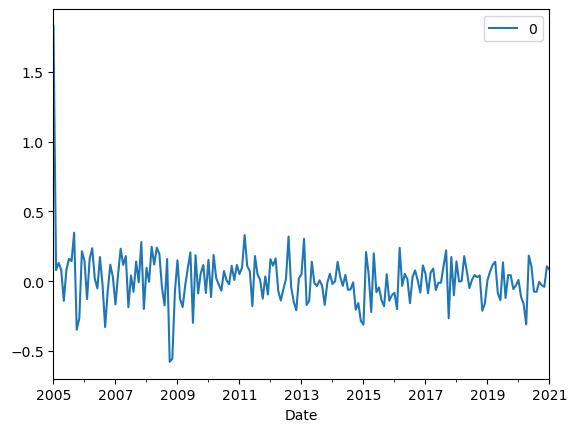

In [18]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

The mean of the residuals is certainly close to 0 and the variance of the residuals appears to be fairly constant thorughout the series. 

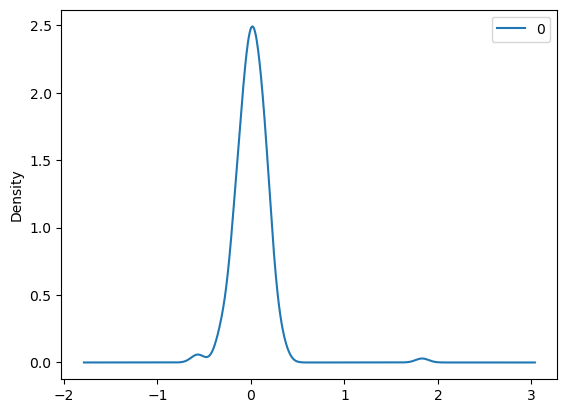

In [19]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals

The Kernel Density Estimate plot demonstrates that the residuals are centered on 0 and normally distributed..

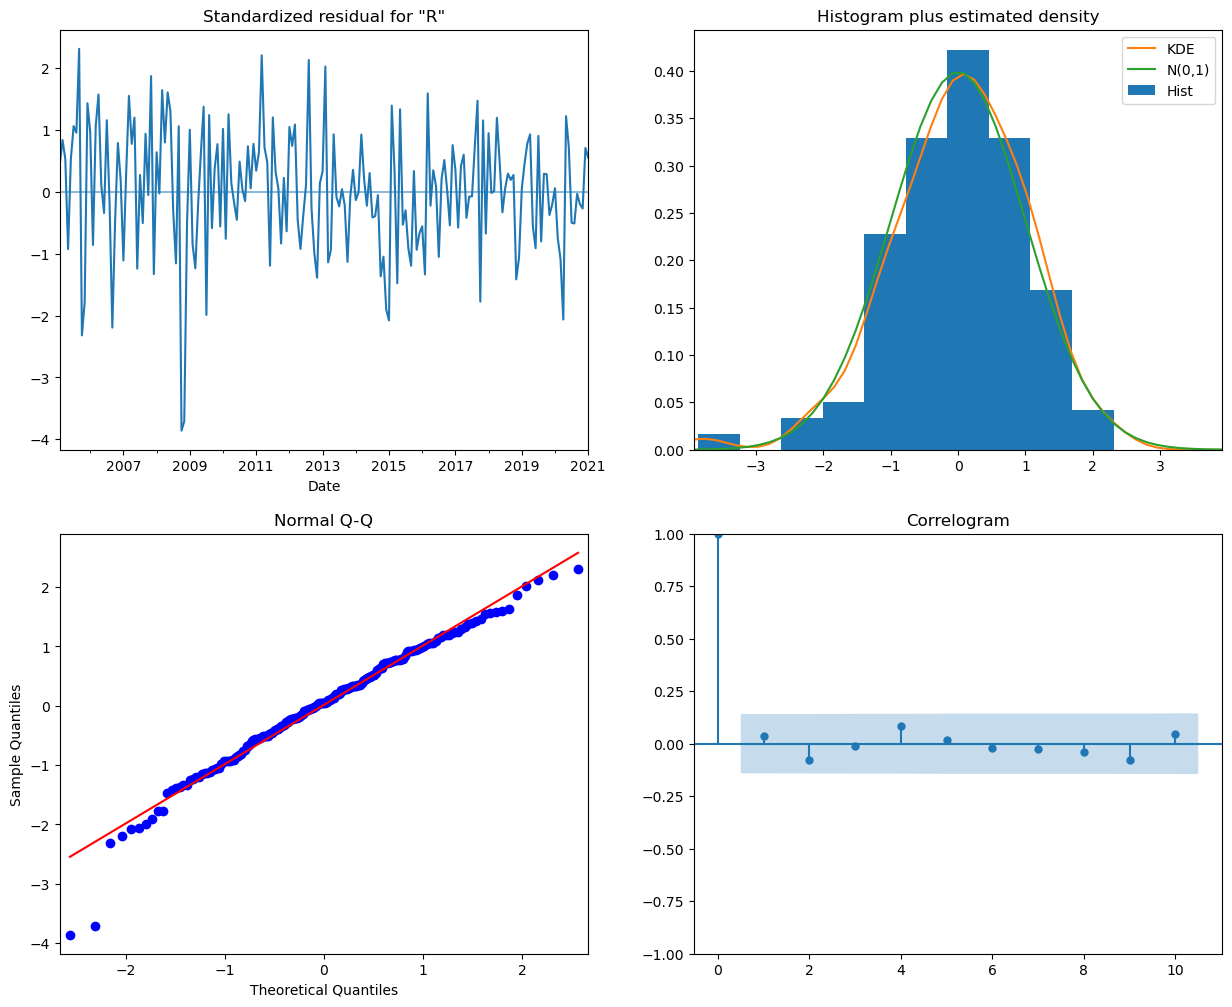

In [20]:
# create graphs using plot_diagnostics method
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

The graphs above provide further evidence that the errors between predicted and actual values in the time series are normally distributed around a near 0 mean. 

# Predict future gas prices
The model will be used to predict 6 months of future gas prices.

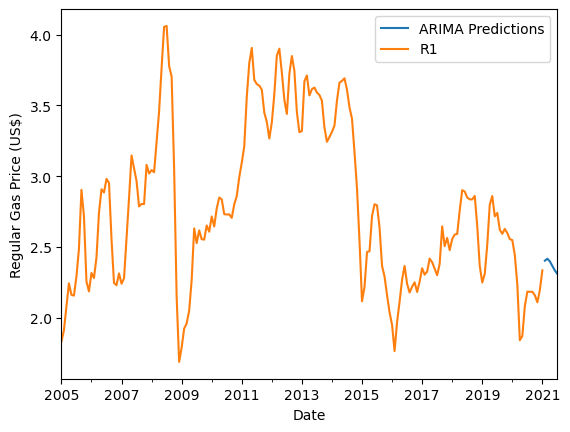

In [23]:
start=len(gas_df['R1'])
end=len(gas_df['R1'])+5
pred=model_fit.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
gas_df['R1'].plot(legend=True)
plt.ylabel('Regular Gas Price (US$)')
plt.show()

# Prediction Results
Predicted gas prices are listed in the table below.

In [22]:
print(pred.tail(6))

2021-02-28    2.402496
2021-03-31    2.416170
2021-04-30    2.397035
2021-05-31    2.364687
2021-06-30    2.332888
2021-07-31    2.308959
Freq: M, Name: ARIMA Predictions, dtype: float64


The model predicted that the price of regular gas would rise in February and March before falling through July 2021.